In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                              std=[0.229, 0.224, 0.225] ,inplace=True)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

data_dir = './chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['val'].classes

device = "cpu"
print(class_names)

['NORMAL', 'PNEUMONIA']


In [10]:
train_pneumonia_size = len(os.listdir(data_dir + "/train/PNEUMONIA"))
print("Train dir size (pneumonia):", train_pneumonia_size)
train_normal_size = len(os.listdir(data_dir + "/train/NORMAL"))
print("Train dir size (normal):", train_normal_size)

Train dir size (pneumonia): 3875
Train dir size (normal): 1341


In [ ]:
def display_images(dir_name, image_count=9):
    i = 0
    plt.figure(figsize=(18, 5))
    for filename in os.listdir(dir_name):
        if i == image_count: break
        plt.subplot(3, 3, i + 1)
        img = plt.imread(os.path.join(dir_name, filename))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        i += 1
    plt.show()

In [ ]:
display_images(data_dir + "/train/PNEUMONIA")

In [ ]:
display_images(data_dir + "/train/NORMAL")

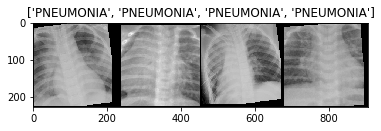

In [4]:
# def imshow(inp, title):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
# #     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     plt.title(title)
#     plt.show()


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
def resnet(weights):
    model_conv = torchvision.models.resnet50(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss(weights)

    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

    model_conv = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=10)
    return model_conv

In [21]:
def densenet(weights):
    model_dense = torchvision.models.densenet121(pretrained=True)
    for param in model_dense.parameters():
        param.requires_grad = False

    num_ftrs = model_dense.classifier.in_features
    model_dense.classifier = nn.Linear(num_ftrs, 2)

    model_dense = model_dense.to(device)

    criterion = nn.CrossEntropyLoss(weights)

    optimizer_dense = optim.SGD(model_dense.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dense, step_size=7, gamma=0.1)

    model_dense = train_model(model_dense, criterion, optimizer_dense,
                             exp_lr_scheduler, num_epochs=10)
    return model_dense

In [30]:
def test_model(model_conv, criterion):
    model_conv.eval()
    phase = 'test'
    running_loss = 0.0
    running_corrects = 0
    
    y_true = []
    y_pred = []

    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        y_true.append(labels.data)

        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        y_pred.append(preds)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[phase]
    test_acc = running_corrects.double() / dataset_sizes[phase]
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, test_loss, test_acc))
    
    return [y_true, y_pred]

In [23]:
pn_count, norm_count = len(os.listdir(data_dir + '/train/PNEUMONIA')), len(os.listdir(data_dir + '/train/NORMAL'))
weight_for_pn = pn_count / (pn_count + norm_count)
weight_for_n = norm_count / (pn_count + norm_count)
weights = torch.FloatTensor([weight_for_pn, weight_for_n]).to(device)

In [25]:
model_res = resnet(weights)

In [26]:
model_dense = densenet(weights)

Epoch 0/9
----------
train Loss: 0.4225 Acc: 0.8464
val Loss: 0.2829 Acc: 0.8750

Epoch 1/9
----------
train Loss: 0.4167 Acc: 0.8639
val Loss: 0.3679 Acc: 0.7500

Epoch 2/9
----------
train Loss: 0.3947 Acc: 0.8658
val Loss: 0.2537 Acc: 0.8750

Epoch 3/9
----------
train Loss: 0.3728 Acc: 0.8738
val Loss: 0.3725 Acc: 0.8750

Epoch 4/9
----------
train Loss: 0.3822 Acc: 0.8700
val Loss: 1.7390 Acc: 0.6250

Epoch 5/9
----------
train Loss: 0.3912 Acc: 0.8729
val Loss: 0.3972 Acc: 0.6875

Epoch 6/9
----------
train Loss: 0.3747 Acc: 0.8758
val Loss: 0.5320 Acc: 0.7500

Epoch 7/9
----------
train Loss: 0.2810 Acc: 0.9022
val Loss: 0.6063 Acc: 0.7500

Epoch 8/9
----------
train Loss: 0.2898 Acc: 0.8963
val Loss: 0.7797 Acc: 0.6250

Epoch 9/9
----------
train Loss: 0.2808 Acc: 0.8967
val Loss: 0.6315 Acc: 0.7500

Training complete in 191m 6s
Best val Acc: 0.875000


In [33]:
criterion = nn.CrossEntropyLoss(weights)
y = test_model(model_dense, criterion)

test Loss: 0.3862 Acc: 0.8862
